# Imports and Loading the Network

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import networkx as nx
import pandas as pd
import numpy as np
import geopandas as gpd

In [2]:
G = nx.read_edgelist("data/sbb.edgelist", delimiter=";", create_using=nx.Graph)

connected_comp = nx.connected_components(G)
max_connected_comp = max(connected_comp)
G = G.subgraph(max_connected_comp)

# 1. Benchmarks: Iteration Time, Silhouette Index and Modularity

This notebook contains the code to benchmark and evaluate the community detection algorithms. 
We measure them on the largest connected component of the Swiss train network.

This section contains the code to run and perform the benchmarks.

Secion 2 contains the visualization of the benchmarks results. 
We provide the data for the benchmarks with the project under `data/benchmarks`.
If you are only interested in the visualization, you can skip directly to section 2.

In [3]:
from sklearn.metrics import silhouette_score
import time
import os

# create directory to save benchmarks results
if not os.path.exists("data/benchmarks"):
    os.makedirs("data/benchmarks")

# Run the single iteration benchmark multiple time (default of 10).
# This functions takes a the graph and callable.
# The leiden boolean flag must be set to true to benchmark the reference leidenalg.
# time_threshold is the maximum number of hours the benchmark runs for, necessary for Girvan-Newman.
def multi_iter_benchmark(G, community_detec_func, iters=10, time_threshold=8, leiden=False):
    times = []
    scores_hops = []
    scores_coords = []
    modularities = []
    
    for _ in range(iters):
        partitions = community_detec_func(G)
        t, s_hops, s_coords, m = single_iter_benchmark(G, partitions, time_threshold, leiden)
        times.append(t)
        scores_hops.append(s_hops)
        scores_coords.append(s_coords)
        modularities.append(m)

    max_len_iteration = max([len(t) for t in times])
    
    for (t, s_hops, s_coords, m) in zip(times, scores_hops, scores_coords, modularities):
        while len(t) < max_len_iteration:
            t.append(np.nan)
            s_hops.append(np.nan)
            s_coords.append(np.nan)
            m.append(np.nan)

    mean_times = np.nanmean(times, axis=0)
    mean_scores_hops = np.nanmean(scores_hops, axis=0)
    mean_scores_coords = np.nanmean(scores_coords, axis=0)
    mean_modularities = np.nanmean(modularities, axis=0)

    return mean_times, mean_scores_hops, mean_scores_coords, mean_modularities

# Perform the benchmark once of a community detection algorithm.
# You must give it a partition scheme before entering the function, not a callable.
def single_iter_benchmark(G, partitions, time_threshold=12, leiden=False):
    timeout = time.time() + 60 * 60 * time_threshold

    i_time = []
    i_silhouette_hops = []
    i_silhouette_coords = []
    i_modularity = []
    
    while True:
        # timeout necessary for Girvan Newman
        if time.time() > timeout:
            break
            
        start = time.time()
        communities = next(partitions, 'finished')
        stop = time.time()
        
        if communities == 'finished':
            break
        
        time_diff = stop - start
        i_time.append(time_diff)

        # necessary for leiden: convert node ids from igraph to node names
        if leiden == True:
            communities = convert_leiden(G, communities)
        
        i_silhouette_hops.append(silhouette_hops(G, communities))
        i_silhouette_coords.append(silhouette_coordinates(G, communities))
        i_modularity.append(nx.community.modularity(G, communities))
        
        final_communities = communities
        
    return i_time, i_silhouette_hops, i_silhouette_coords, i_modularity


# silhouette score with shortest path between nodes
def silhouette_hops(G, found_communities):
    # make a dictionary with node as key and final community as value
    node_to_community = {node: comm_idx for comm_idx, community in enumerate(found_communities) for node in community}
    # list all final communities by indexing with keys
    comm_labels = [node_to_community[node] for node in sorted(G.nodes())]
    
    # calc silhouette score by hop matrix as an array and the communities as labels
    sil_score = silhouette_score(hop_mat, comm_labels, metric='precomputed', random_state=42)

    return sil_score

# silhouette score with coordinates of each station
def silhouette_coordinates(G, found_communities):
    # make a dictionary with node as key and final community as value
    node_to_community = {node: comm_idx for comm_idx, community in enumerate(found_communities) for node in community}
    # list all final communities by indexing with keys
    comm_labels = [node_to_community[node] for node in sorted(G.nodes())]
    
    # calc silhouette score by inputting coordinate matrix as an array and the communities as labels
    sil_score = silhouette_score(coordinates_mat, comm_labels, metric='euclidean', random_state=42)

    return sil_score

# create the coordinate matrix for the silhouette index with coordinates
stations_gdf = gpd.read_file('data/stations.geojson')
stations_gdf = stations_gdf[stations_gdf["station_name"].isin(list(G.nodes))] # G is the Largest Connected Component Graph
coordinates_mat = np.column_stack((stations_gdf["geometry"].x, stations_gdf["geometry"].y))

# create the hop matrix for silhouette index with path length
length = dict(nx.all_pairs_shortest_path_length(G))
df = pd.DataFrame(length)
df = df.sort_index().sort_index(axis=1)
hop_mat = df.to_numpy()

## 1.1 Louvain

In [4]:
t, s_hops, s_coords, m = multi_iter_benchmark(G, nx.community.louvain_partitions)

louvain_bench = pd.DataFrame(zip(t, s_hops, s_coords, m), columns=["time", "silhouette hops", "silhouette coordinates", "modularity"])
louvain_bench.to_csv("./data/benchmarks/louvain.csv", index=False)
louvain_bench

,time,silhouette hops,silhouette coordinates,modularity
0,0.184424,0.345150,0.141561,0.560949
1,0.056035,0.310297,0.046516,0.818525
2,0.017394,0.217720,-0.072155,0.896722
3,0.005865,0.143233,-0.065694,0.906036
4,0.002110,0.138818,-0.052318,0.905901


## 1.2 Louvain Implementation

In [5]:
# from louvain import louvain_generator
# remade the graph due to a frozen graph error
# G = nx.read_edgelist("data/sbb.edgelist", delimiter=";", create_using=nx.Graph)
# connected_comp = nx.connected_components(G)
# max_connected_comp = max(connected_comp)
# sub_G = G.subgraph(max_connected_comp)
# G = nx.Graph(sub_G)

# t, s_hops, s_coords, m = multi_iter_benchmark(G, louvain_generator)

# louvain_imp_bench = pd.DataFrame(zip(t, s_hops, s_coords, m), columns=["time", "silhouette hops", "silhouette coordinates", "modularity"])
# louvain_imp_bench.to_csv("./data/benchmarks/louvain_imp.csv", index=False)
# louvain_imp_bench

## 1.3 Girvan-Newman

Because Girvan-Newman is much slower than other community detection algorithms benchmarked in this notebook, we run it only once.
Data available in `data/benchmarks` for this algorithm consists of an 8 hours run, with a total of 2310 iterations. 

In [6]:
gn_partitions = nx.community.girvan_newman(G)
t, s_hops, s_coords, m = single_iter_benchmark(G, gn_partitions, time_threshold=8)

gn_bench = pd.DataFrame(zip(t, s_hops, s_coords, m), columns=["time", "silhouette hops", "silhouette coordinates", "modularity"])
gn_bench.to_csv("./data/benchmarks/girvan-newman.csv", index=False)
gn_bench

,time,silhouette hops,silhouette coordinates,modularity
0,576.872154,0.167379,0.392112,0.473497
1,415.905321,0.187742,0.134926,0.574120
2,45.090504,0.209416,0.031870,0.610589
3,527.572969,0.140233,0.077071,0.707030
4,109.642415,0.144387,0.104976,0.740414
...,...,...,...,...
2305,7.063219,0.083433,0.023070,0.187726
2306,7.159345,0.083212,0.022727,0.187506
2307,7.153501,0.082991,0.022231,0.187286
2308,7.127675,0.082770,0.022032,0.187065


## 1.4 Leiden

The reference implementation of Leiden does not have a generator, like the NetworkX algorithms do.
To measure each iteration of Leiden, we created a generator.

In [7]:
import leidenalg as la
import igraph as ig

# convert from igraph ids to node names
def convert_leiden(G, partition):
    idx2name = {idx: name for idx, name in enumerate(list(G.nodes))}
    
    communities = []
    for comm in partition:
        communities.append({idx2name[n] for n in comm})
        
    return communities

# generator for leidenalg
def leiden_gen(G):
    graph = ig.Graph.from_networkx(G, vertex_attr_hashable='name')

    # create the partition with every node as its community
    partition = la.ModularityVertexPartition(graph)
    optimiser = la.Optimiser()
        
    diff = 1
    while diff > 0:
        diff = optimiser.optimise_partition(partition)
        yield partition

In [8]:
t, s_hops, s_coords, m = multi_iter_benchmark(G, leiden_gen, leiden=True)

leiden_bench = pd.DataFrame(zip(t, s_hops, s_coords, m), columns=["time", "silhouette hops", "silhouette coordinates", "modularity"])
leiden_bench.to_csv("./data/benchmarks/leiden.csv", index=False)
leiden_bench

,time,silhouette hops,silhouette coordinates,modularity
0,0.087021,0.145880,-0.022479,0.908671
1,0.042471,0.147817,-0.010013,0.909395
2,0.041384,0.147105,-0.000403,0.909637
3,0.041046,0.146431,0.006590,0.909804
4,0.041988,0.146665,0.004179,0.909841
5,0.042443,0.145111,0.004023,0.909874
6,0.040540,0.146358,0.001984,0.909802
7,0.043450,0.147593,-0.009183,0.909351


# 2. Evaluation of the Community Detection Algorithms

In [9]:
def plot_bench_results(df_list, labels):
    fig, axs = plt.subplots(nrows=1, ncols=len(df_list[0].columns), figsize=(18, 6), layout="tight")
    # iterate over the columns
    for i, col in enumerate(df_list[0].columns):
        # iterate over the dataframe: all in the same plot
        for df, label in zip(df_list, labels):
            axs[i].plot(df[col], label=label)
        
        axs[i].set_xlabel('Iteration')
        axs[i].set_ylabel(col)
        axs[i].set_title(f'{col} v. iteration')
            # force int on x-axis
        axs[i].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        axs[i].legend()
    
    # plt.savefig("community-detection-benchmarks.png")
    plt.show()

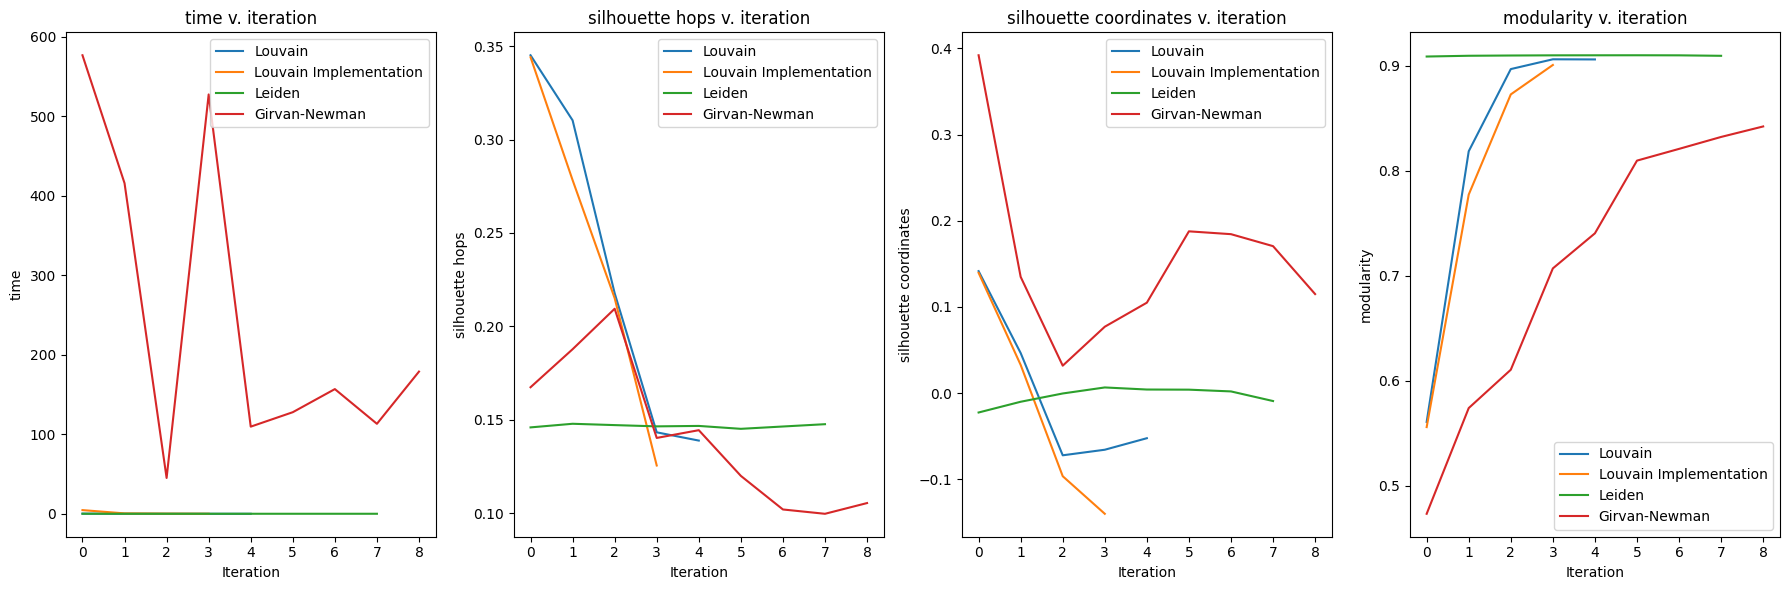

In [10]:
louvain_bench = pd.read_csv("data/benchmarks/louvain.csv")
louvain_imp_bench = pd.read_csv("data/benchmarks/louvain_imp.csv")
gn_bench = pd.read_csv("data/benchmarks/girvan-newman.csv")
leiden_bench = pd.read_csv("data/benchmarks/leiden.csv")

algorithm_data = [louvain_bench, louvain_imp_bench, leiden_bench, gn_bench[:9]]
algorithm_name = ["Louvain", "Louvain Implementation", "Leiden", "Girvan-Newman"]

plot_bench_results(algorithm_data, algorithm_name)

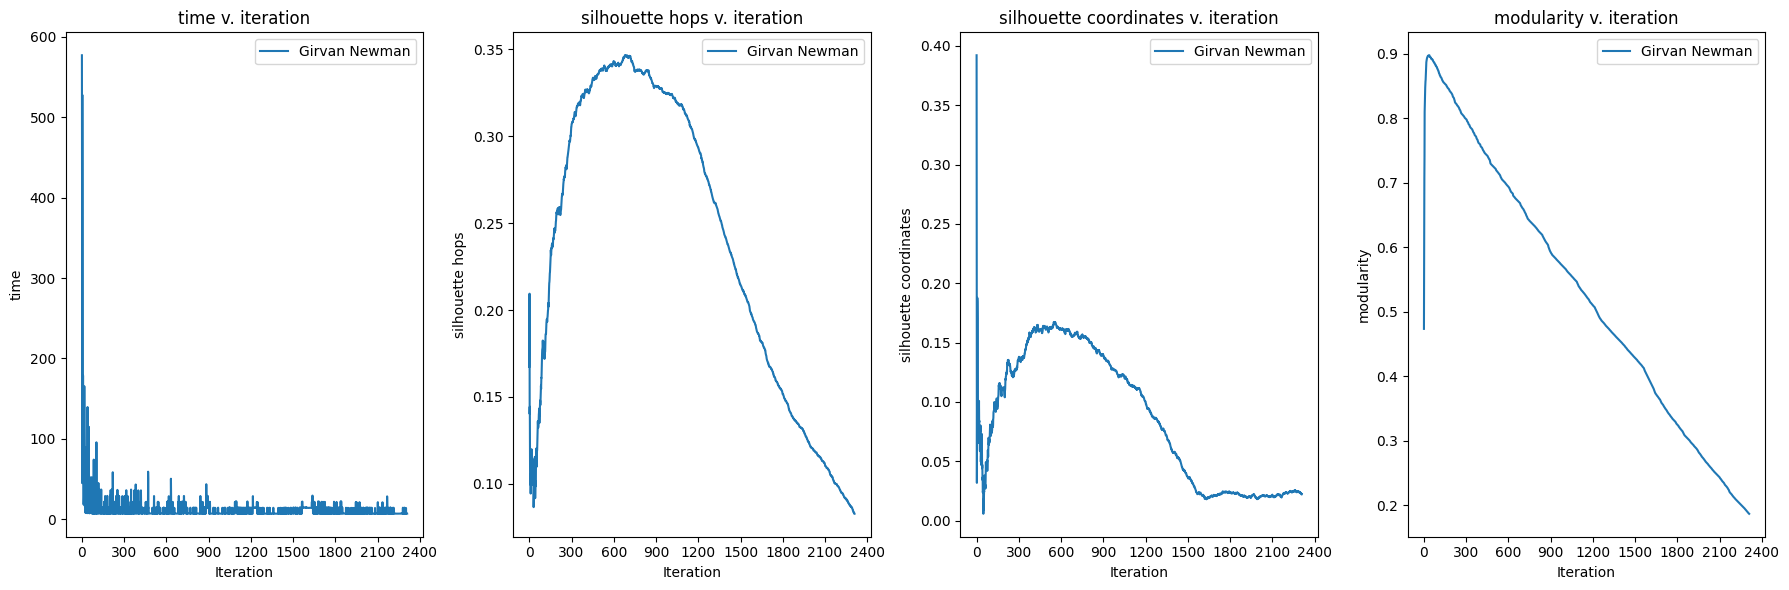

In [15]:
plot_bench_results([gn_bench], ["Girvan Newman"])

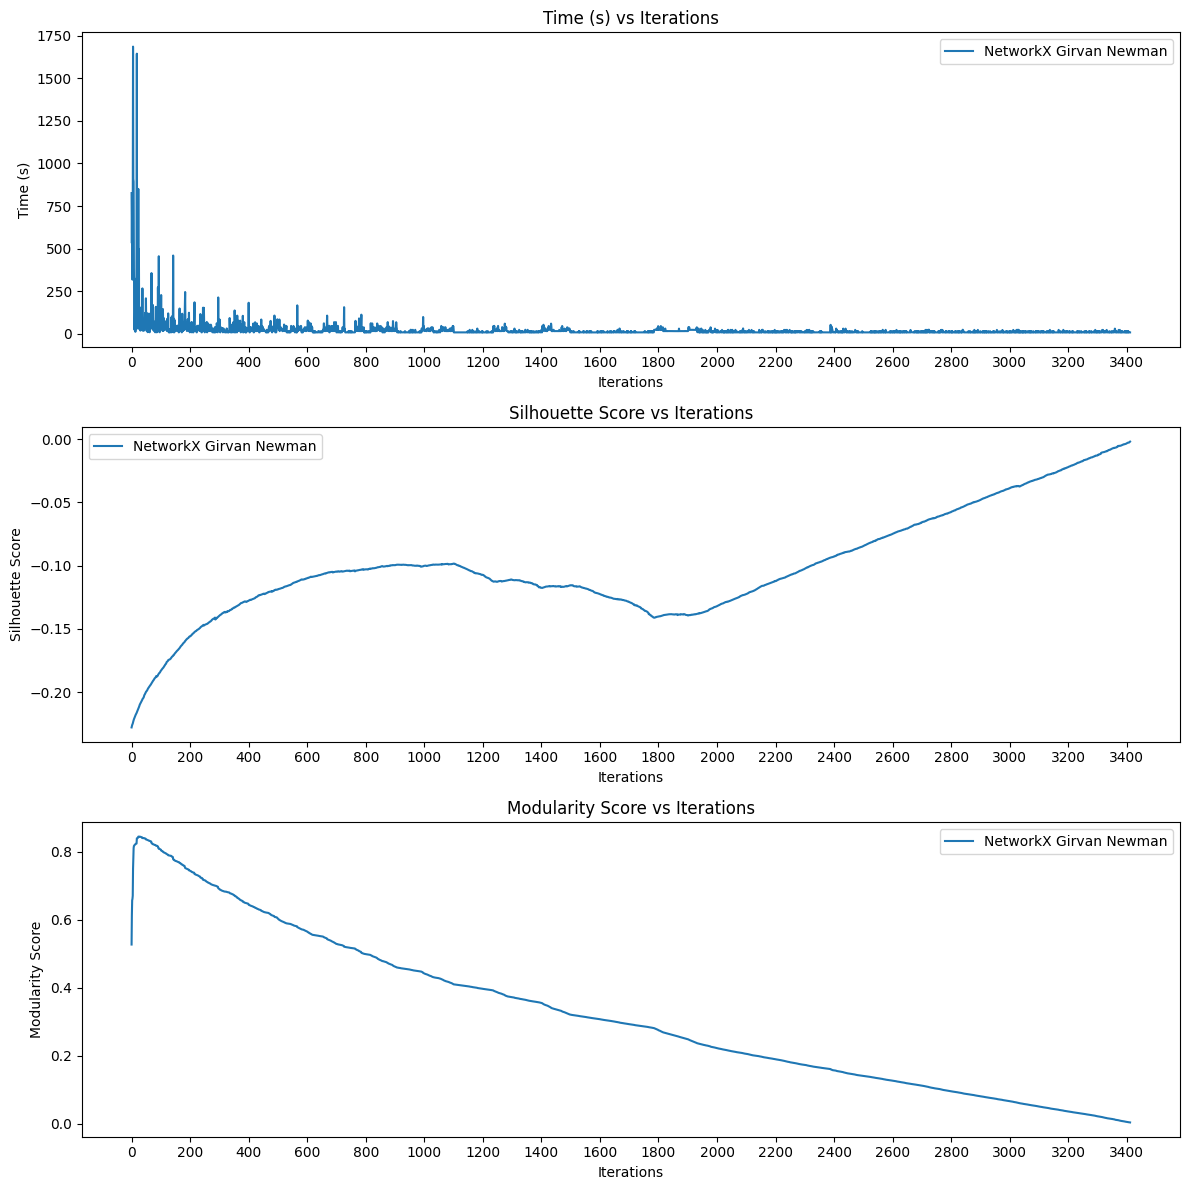

In [11]:
# we should be able to safely remove this
# kept just in case
#def eval_plots(*datasets, tick_int):
    for i, (data, label, ylabel) in enumerate(datasets):
        for d, l in zip(data, label): 
            ax[i].plot(d, label=l)
        ax[i].set_xlabel('Iterations')
        ax[i].set_ylabel(ylabel)
        ax[i].set_title(f'{ylabel} vs Iterations')
        ax[i].xaxis.set_major_locator(ticker.MultipleLocator(tick_int))
        ax[i].legend()
        
    plt.tight_layout()
    plt.show()


# Just Girvan Newman plots
# read nx gn csvs
nx_gn_times = pd.read_csv("data/communities/nx_gn_iteration_times.csv")
nx_gn_m_times = nx_gn_times.mean(axis='rows')

nx_gn_sil = pd.read_csv("data/communities/nx_gn_silhouette_scores_per_iteration.csv")
nx_gn_m_sil = nx_gn_sil.mean(axis='rows')

nx_gn_mod = pd.read_csv("data/communities/nx_gn_modularity_scores_per_iteration.csv")
nx_gn_m_mod = nx_gn_mod.mean(axis='rows')

fig, ax = plt.subplots(3, 1, figsize=(12, 12))

eval_plots(((nx_gn_m_times,), ('NetworkX Girvan Newman',), 'Time (s)'),
            ((nx_gn_m_sil,), ('NetworkX Girvan Newman',), 'Silhouette Score'),
            ((nx_gn_m_mod,), ('NetworkX Girvan Newman',), 'Modularity Score'),
           tick_int=200)
